The unreasonable effectiveness of equilibrium gene regulation through the cell cycle
===

_Jose M. G. Vilar$^{1, 2, *}$ and Leonor Saiz$^{3, *}$  
$^1$Biofisika Intitute (CSIC, UPV/EHU), University of the Basque Country, P.O. Box 644, 48080 Bilbao, Spain  
$^2$IKERBASQUE, Basque Foundation for Science, 48011 Bilbao, Spain  
$^3$Department of Biomedical Engineering, University of California, 451 East Health Sciences Drive, Davis, CA 95616, USA_

$^*$ To whom correspondence should be addressed: j.vilar@ikerbasque.org or lsaiz@ucdavis.edu

SUMMARY: 
Notebook to reproduce Figures 3, 4, 5, and 6 of reference [1].

This notebook is provided to ensure the reproducibility of the analyses and has not been optimized for general usage. It was executed with python 3.10.12 from the conda 23.5.2 (https://conda.io/) distribution with the additional packages CplexA [2], matplotlib 3.7.2, numpy 1.25.1, and scipy 1.11.1.

REFERENCES:

[1] J.M.G. Vilar and L. Saiz, The unreasonable effectiveness of equilibrium gene regulation through the cell cycle, submitted (2024).
[2] J.M.G. Vilar and L. Saiz, CplexA: a Mathematica package to study macromolecular-assembly control of gene expression, Bioinformatics 26, 2060-2061 (2010).

In [1]:
import numpy as np
import sympy as sp
import CplexA as cp

import matplotlib.pyplot as plt


In [2]:
AF=cp.AveConf('G*(1-s1)*(X*s3+(1-s3))',
              '(g1-kT*ln(n))*s1+(g2-kT*ln(n))*s2+(g3-kT*ln(n))*s3\
              +((gL12+kT*ln(n))*s1*s2)*sL2+((gL13+kT*ln(n))*s1*s3)*sL3\
              +inf*(1-s1*s2)*sL2+inf*(1-s1*s3)*sL3+inf*sL2*sL3',
              's1 s2 s3 sL2 sL3','kT')

In [3]:
def ref0(RL):
    nu,de=sp.fraction(RL)
    de0=de.subs('n',0)
    n=sp.sympify('n')
    res=sp.collect(sp.powsimp(sp.expand(nu/de0,n)),n)/sp.collect(sp.powsimp(sp.expand(de/de0,n)),n)
    return res

    
RL=sp.simplify(AF.subs('n',0)/AF)
RL=ref0(RL)
display(RL)
ref0(RL.subs({'g3':'kT*oo'}))

(n**3*exp(-(g1 + g2 + g3)/kT) + n**2*(exp(-(g1 + g2 + g3 + gL13)/kT) + exp(-(g1 + g2 + g3 + gL12)/kT) + exp(-(g2 + g3)/kT) + exp(-(g1 + g3)/kT) + exp(-(g1 + g2)/kT)) + n*(exp(-(g1 + g3 + gL13)/kT) + exp(-(g1 + g2 + gL12)/kT) + exp(-g3/kT) + exp(-g2/kT) + exp(-g1/kT)) + 1)/(X*n**2*exp(-(g2 + g3)/kT) + n*(X*exp(-g3/kT) + exp(-g2/kT)) + 1)

(n**2*exp(-(g1 + g2)/kT) + n*(exp(-(g1 + g2 + gL12)/kT) + exp(-g2/kT) + exp(-g1/kT)) + 1)/(n*exp(-g2/kT) + 1)

In [4]:
vals={
    'kT':1,
    'g1':-12.7/0.6-np.log(1.5e-9),
    'g2':-11.3/0.6-np.log(1.5e-9),
    'g3':-9.1/0.6-np.log(1.5e-9),
    'gL12':8.25/0.6+np.log(1.5e-9),
    'gL13':7.05/0.6+np.log(1.5e-9),
    'X':0.03,
    'n':'n',
}
fc=1

In [5]:
vals

{'kT': 1,
 'g1': -0.8488659378284211,
 'g2': 1.484467395504911,
 'g3': 5.151134062171581,
 'gL12': -6.567800728838247,
 'gL13': -8.567800728838247,
 'X': 0.03,
 'n': 'n'}

In [6]:
rvn=1+np.random.rand(10000, 3)*0.3-0.15
rvd=1+np.random.rand(10000, 3)*0.3-0.15
rv=rvn.mean(axis=1)/rvd.mean(axis=1)
rv.std()
rvp=np.percentile(rv,[2.5,97.5])
rvp

array([0.87184537, 1.1452982 ])

In [7]:
rvp=np.array([1-0.173,1+0.173])
rvp

array([0.827, 1.173])

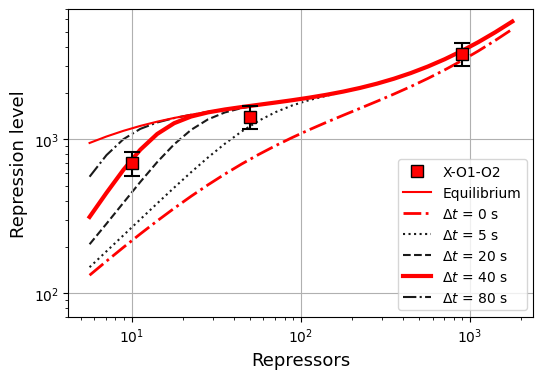

In [8]:
RL_f=cp.pythonFunction(RL.subs({'g3':sp.oo}).subs(vals),'n')

def mina(x,y):
    return y*(x>=y)+x*(x<y)

def kin(x,n):
    return x*0.3*n/fc

def alp(x,n,dt):
    return (np.exp(-kin(x,n)*dt)-np.exp(-kin(x,n)*90))/(90)/kin(x,n)


expR12=np.array([(1300,6700,16000),(700,1400,3600),(440,3900,15000),(18,140,2700)])
expN12=np.array([10,50,900])
xt=fc*10**np.arange(0.75,3.25+1e-4,0.1)

plt.figure(figsize=(6,4))
for i in (1,):
    plt.plot(expN12,expR12[i],'s', c='red', ms=8,mec='k',zorder=6, label='X-O1-O2')
    plt.errorbar(expN12,expR12[i],yerr=np.abs((rvp-1)[:,np.newaxis]*expR12[i]),capsize=6, fmt="none", ecolor = "black", capthick=1.5, zorder=5)
REv=RL_f(xt)
plt.plot(xt/fc,REv,'-',c='red',lw=1.5,label='Equilibrium', zorder=4)
iv=40/60
lss=[ '-.', '--',':']
for i in (0,5/60,20/60,iv,80/60):
    plt.plot(xt/fc,REv/((REv-1)*alp(1,xt,i)+1),
             '-' if i==iv else '-.' if i==0 else lss.pop(), 
             lw=3 if i==iv else 2 if i==0 else 1.5,
             zorder=4 if i in (0,iv) else 0,
             color='red' if i in (0,iv) else '0.1',
             label=f'$\Delta t$ = {i*60:.0f} s')
plt.ylim(7e1,7e3)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Repression level',size=13)
plt.xlabel('Repressors',size=13)

plt.grid()
plt.legend()
for ex in ['.pdf','.svg','.png']:
    plt.savefig('fig3top'+ex,transparent=True, bbox_inches='tight')
plt.show()


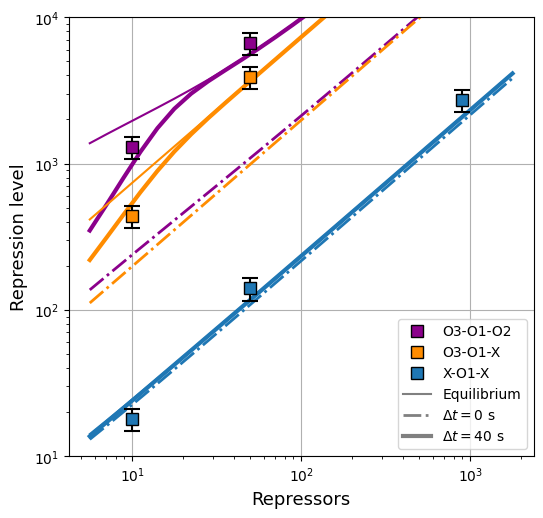

In [9]:
RL_f=cp.pythonFunction(RL.subs({'g2':sp.oo}).subs({'g3':sp.oo}).subs(vals),'n')

expR12=np.array([(1300,6700,16000),(700,1400,3600),(440,3900,15000),(18,140,2700)])
expN12=np.array([10,50,900])
xt=fc*10**np.arange(0.75,3.25+1e-4,0.1)

plt.figure(figsize=(6,5.7))
dl=[{},{'g3':sp.oo},{'g2':sp.oo},{'g2':sp.oo,'g3':sp.oo}]
cl=['darkmagenta','red','darkorange','tab:blue']
la=['O3-O1-O2','X-O1-O2','O3-O1-X','X-O1-X',]
for k in range(1):
    for i in (0,2,3):
        plt.plot(expN12,expR12[i],'s',c=cl[i],ms=8,mec='k',zorder=8,label=la[i])
        plt.errorbar(expN12,expR12[i],yerr=np.abs((rvp-1)[:,np.newaxis]*expR12[i]),capsize=6, fmt="none", ecolor = "black", capthick=1.5, zorder=5)
        RL_f=cp.pythonFunction(RL.subs(dl[i]).subs(vals),'n')
        REv=RL_f(xt)
        iv=40/60; a=(1-iv/90)
        plt.plot(xt/fc,REv*a/((REv*a-1)*alp(1,xt,iv)+1),'-',lw=3,c=cl[i],) if k==0 else plt.plot(xt,REv,'-',lw=3,c=cl[i])
        plt.plot(xt/fc,REv,'-',lw=1.5,c=cl[i],)
        iv2=0.0; a=1-iv2/90
        plt.plot(xt/fc,REv*a/((REv*a-1)*alp(1,xt,iv2)+1),'-.',lw=2,c=cl[i],)

    plt.plot((xt/fc)[:1],REv[:1],'-',lw=1.5,c='grey',label='Equilibrium',zorder=-10)
    plt.plot((xt/fc)[:1],(REv*a/((REv*a-1)*alp(1,xt,iv)+1))[:1],'-.',lw=2,c='grey',label=f'$\Delta t = ${iv2*60:.0f} s',zorder=-10)
    plt.plot((xt/fc)[:1],(1+0*REv*a/((REv*a-1)*alp(1,xt,iv)+1))[:1],'-',lw=3,c='grey',label=f'$\Delta t = ${iv*60:.0f} s',zorder=-10)

    plt.ylim(1e1,1e4)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Repression level',size=13)
    plt.xlabel('Repressors',size=13)
    
    plt.grid()
    plt.legend()
    for ex in ['.pdf','.svg','.png']:
        plt.savefig('fig3bottom'+ex,transparent=True, bbox_inches='tight')
    plt.show()


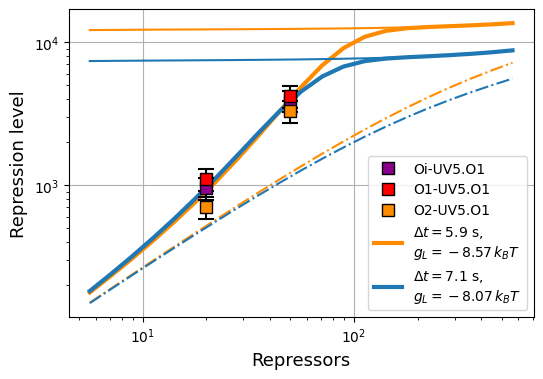

In [10]:
aaav=((3900, 950), (4200, 1100), (3300, 700), (1300, 140))

xt=fc*10**np.arange(0.75,2.75+1e-4,0.1)
dl=[{'g3':vals['g1']-1.1/0.6},{'g3':vals['g1']},{'g3':vals['g2']},{'g3':vals['g3']},]
leg=['Oi-UV5.O1','O1-UV5.O1','O2-UV5.O1','O3-UV5.O1']

plt.figure(figsize=(6,4))
for i in range(3):
    plt.plot((50,20),aaav[i],'s',c=cl[i],ms=8,mec='k',zorder=8,label=leg[i])
    plt.errorbar((50,20),aaav[i],yerr=np.abs((rvp-1)[:,np.newaxis]*aaav[i]),capsize=6, fmt="none", ecolor = "black", capthick=1.5, zorder=5)

valsc={'X':1,'g2':sp.oo, 'gL13':vals['gL13']}
RL_f=cp.pythonFunction(RL.subs(dl[0]).subs(valsc).subs(vals),'n')
REv=RL_f(xt)
col='darkorange'
plt.plot(xt/fc,REv,lw=1.5,c=col)
iv=5.9/60
plt.plot(xt/fc,REv/((REv-1)*alp(1,xt,iv)+1),lw=3,c=col, label=f'$\Delta t = ${iv*60:.1f} s,\n$g_L={vals["gL13"]:.2f}\,k_BT$')
plt.plot(xt/fc,REv/((REv-1)*alp(1,xt,0.0)+1),'-.',lw=1.5,c=col)

valsc={'X':1,'g2':sp.oo, 'gL13':vals['gL13']+0.3/0.6}
RL_f=cp.pythonFunction(RL.subs(dl[0]).subs(valsc).subs(vals),'n')
REv=RL_f(xt)
col='tab:blue'
plt.plot(xt/fc,REv,lw=1.5,c=col)
iv=7.1/60
plt.plot(xt/fc,REv/((REv-1)*alp(1,xt,iv)+1),lw=3,c=col, label=f'$\Delta t = ${iv*60:.1f} s,\n$g_L={vals["gL13"]+0.3/0.6:.2f}\,k_BT$')
plt.plot(xt/fc,REv/((REv-1)*alp(1,xt,0.0)+1),'-.',lw=1.5,c=col)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Repression level',size=13)
plt.xlabel('Repressors',size=13)

plt.grid()
plt.legend()
for ex in ['.pdf','.svg','.png']:
    plt.savefig('fig4'+ex,transparent=True, bbox_inches='tight')
plt.show()


In [11]:
def RL_fv(i,x_val,iv,cn):
    valsc={'X':1,'g2':sp.oo, 'gL13':vals['gL13']+x_val}
    RL_f=cp.pythonFunction(RL.subs(dl[i]).subs(valsc).subs(vals),'n')
    REv=RL_f(cn)
    REv/((REv-1)*alp(1,xt,iv)+1)
    return REv/((REv-1)*alp(1,cn,iv)+1)
    
ii=0
gtx=np.argmin([np.mean([(np.log(aaav[ii])-np.log([RL_fv(ii,g,t/60,fc*i) for i in [50,20]]))**2 for ii in [0,]]) for g in np.arange(0,1,0.1) for t in np.arange(0,15,0.1)])
np.array([(g,t) for g in np.arange(0,1,0.1) for t in np.arange(0,15,0.1)])[gtx]

array([0.4, 6.8])

In [12]:
np.mean([(np.log(aaav[ii])-np.log([RL_fv(ii,0,5/60,fc*i) for i in [50,20]]))**2 for ii in [0,1,2]])

0.030654634651675932

In [13]:
np.mean(np.log(aaav[:3]),axis=0)

array([8.23774979, 6.80353593])

In [14]:
nocamp=np.array([254.34782609, 121.875     ,  43.98496241,  13.54166667,
         4.64654488,   2.22942073,   1.09304933,   1.        ])
camp=np.array([1.62601764e+03, 5.70654762e+02, 1.17395670e+02, 2.76059664e+01,
       2.66398499e+00, 1.27756486e+00, 1.06908804e+00, 1.00000000e+00])
iptgv=np.array([1.00000e-02, 5.00000e+00, 1.00000e+01, 2.00000e+01, 5.00000e+01,
       1.00000e+02, 2.00000e+02, 1.00000e+03])



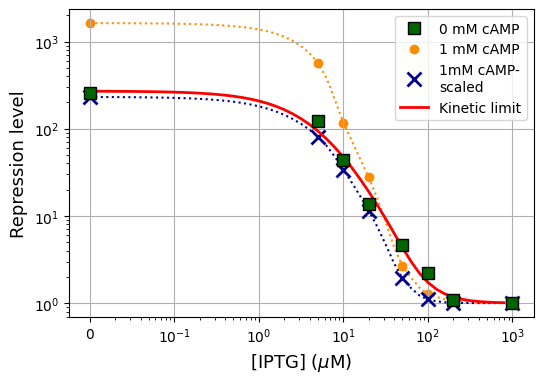

In [15]:
from scipy import interpolate

xIPTG=10**np.arange(np.log10(iptgv[0]),np.log10(iptgv[-1]),0.1)
p0=1/(1+xIPTG/7.2)
xt=fc*10*p0**4
xtm=fc*10*(4*(1-p0)*p0**3+2*(1-p0)**2*p0**2)

p0s=1/(1+iptgv/7.2)
xts=fc*10*p0s**4
xtms=fc*10*(4*(1-p0s)*p0s**3+2*(1-p0s)**2*p0s**2)

campi=np.exp(interpolate.PchipInterpolator(iptgv,np.log(camp))(xIPTG))

plt.figure(figsize=(6,4))
plt.plot(iptgv,nocamp,'s', ms=8,mec='k',zorder=5,label='0 mM cAMP',color="darkgreen")

plt.plot(xIPTG,campi,':',c='darkorange',zorder=1)
plt.plot(iptgv,camp,'o',label='1 mM cAMP',c='darkorange',zorder=1)

iv=0/60
plt.plot(xIPTG,campi/((campi-1)*alp(1,xt+0.5*xtm,iv)+1),':', mew=2, ms=10, color='darkblue',zorder=3)
plt.plot(iptgv,camp/((camp-1)*alp(1,xts+0.5*xtms,iv)+1),'x', mew=2, ms=10, label='1mM cAMP-\nscaled', color='darkblue',zorder=3)

p0=1/(1+xIPTG/7.2)

xt=fc*10*p0**4
xtm=fc*10*(4*(1-p0)*p0**3+2*(1-p0)**2*p0**2)

plt.plot(xIPTG,1/alp(1,xt+0.5*xtm,iv),'-', label='Kinetic limit', color='red', lw=2,zorder=4)

plt.xlim()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Repression level',size=13)
plt.xlabel('[IPTG] ($\mu$M)',size=13)
plt.grid()
plt.legend()

import matplotlib.ticker as mticker

plt.gcf().canvas.draw()
ax=plt.gca()
ticks_loc = ax.get_xticks()[2:-2]
labels = [item.get_text() for item in ax.get_xticklabels()][2:-2]
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
labels[0] = '$\\mathdefault{0}$'
ax.set_xticklabels(labels)
ax.set_xticks(np.concatenate([np.arange(0.2,1,0.1)*10**j for j in range(-1,4)]), minor = True)
for ex in ['.pdf','.svg','.png']:
    plt.savefig('fig5'+ex,transparent=True, bbox_inches='tight')
plt.show()

1300 1955.4544691760173
53.70317963702527 1309.0859201241212
700 1178.552845165323
37.15352290971726 701.3042794721783
440 736.5300106564598
28.183829312644534 442.1931854754323
950 7477.522498288212
7.079457843841379 956.0809578125314
289 1955.4544691760173
4.570881896148751 289.2775666211417
254 1955.4544691760173
1.5488166189124815 253.97809185637487


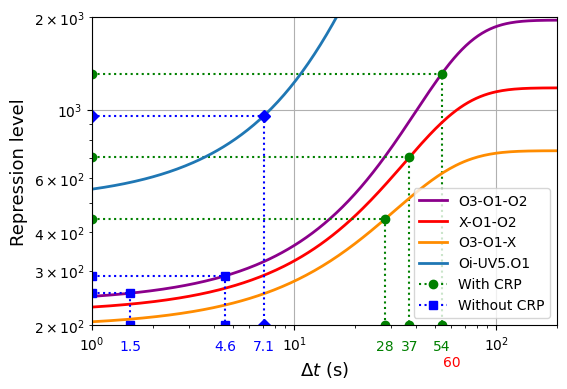

In [16]:
vb=[]
vg=[]
la2=['O3-O1-O2','X-O1-O2','O3-O1-X','Oi-UV5.O1',]
dl=[{},{'g3':sp.oo},{'g2':sp.oo},{'X':1,'g3':vals['g1']-1.1/0.6, 'g2':sp.oo, 'gL13':vals['gL13']+0.3/0.6},{},{},{}]
plt.figure(figsize=(6,4))
for i in range(6):
    val=[1300,700,440,950,289,254,1272][i]
    RL_f=cp.pythonFunction(RL.subs(dl[i]).subs(vals),'n')
    cR=10 if i!=3 else 20
    REv=RL_f(cR)
    print(val,REv)
    dt=10**np.arange(0,np.log10(200)+1e-4,0.01)/60
    RLva=REv/((REv-1)*alp(1,cR,dt)+1)
    if i<4:
        plt.plot(dt*60,RLva,'-', c=cl[i], label=la2[i], lw=2)
    idtm=np.argmin((RLva-val)**2)
    print(dt[idtm]*60,RLva[idtm])
    plt.plot([1,dt[idtm]*60,dt[idtm]*60,],[RLva[idtm],RLva[idtm],200],':og' if i<3 else ':Db' if i==3 else ':sb' )
    if i<3:
        plt.text(dt[idtm]*60, 180, f'{dt[idtm]*60:.0f}',va='top',ha='center', c='g')
        vg.append(dt[idtm]*60)
    else:
            plt.text(dt[idtm]*60, 180, f'{dt[idtm]*60:.1f}',va='top',ha='center', c='b')
            vb.append(dt[idtm]*60)
plt.text(60, 160, f'{60:.0f}',va='top',ha='center', c='r')
vg.append(60)
plt.plot([0.5,],[100,],':og',label='With CRP' )
plt.plot([0.5,],[100,],':sb',label='Without CRP' )

plt.yscale('log')
plt.xscale('log')
plt.xlim(1,200)
plt.ylim(200,2000)
plt.ylabel('Repression level',size=13)
plt.xlabel('$\Delta t$ (s)',size=13)

plt.grid()
plt.legend()
for ex in ['.pdf','.svg','.png']:
    plt.savefig('fig6'+ex,transparent=True, bbox_inches='tight')
plt.show()

In [17]:
np.mean(vb), np.mean(vg), np.mean(vg[:-1])

(4.399718786300871, 44.76013296484676, 39.68017728646235)

In [18]:
np.std(vb), np.std(vg), np.std(vg[:-1])

(2.2611163463136745, 12.697105874280206, 10.570313681856424)